In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fbprophet import Prophet
%matplotlib inline

In [2]:
# plt.style.use("ggplot")
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.sans-serif'] = ['Microsoft Yahei']

In [3]:
file_path = './全部数据/附件1-区域15分钟负荷数据.csv'
data = pd.read_csv(file_path, parse_dates=['数据时间'], index_col=[0])
data

,总有功功率（kw）
数据时间,
2018-01-01 00:00:00,244033.7682
2018-01-01 00:15:00,232720.6402
2018-01-01 00:30:00,231685.6891
2018-01-01 00:45:00,227581.3317
2018-01-01 01:00:00,233482.4269
...,...
2021-08-31 22:45:00,202409.1270
2021-08-31 23:00:00,218576.4635
2021-08-31 23:15:00,200112.5091


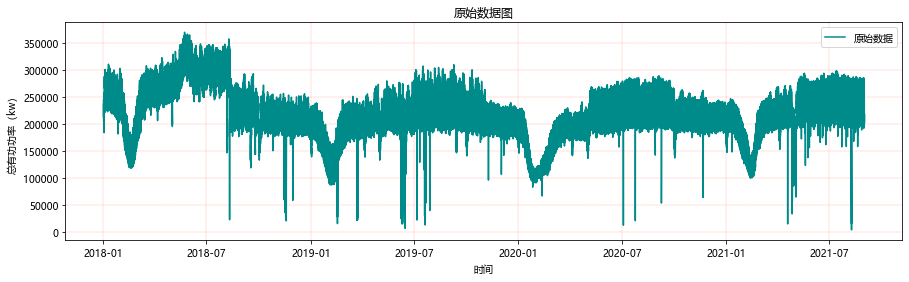

In [4]:
plt.figure(figsize=(15,4))
plt.grid(color = 'tomato', linestyle = '--', linewidth = 0.25)
plt.title('原始数据图')
plt.ylabel('总有功功率（kw）')
plt.xlabel('时间')
plt.plot(data, color='darkcyan', label='原始数据')
plt.legend()
# plt.savefig('每日功率波动曲线去除异常值前后对比图.svg')

In [5]:
window = 960
data_smooth = data.rolling(window, center=True).mean()

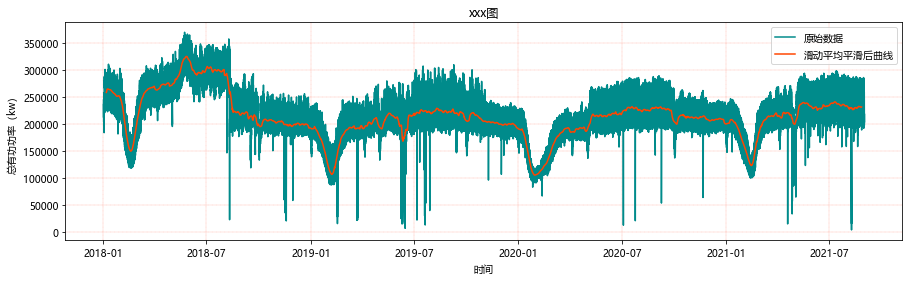

In [6]:
plt.figure(figsize=(15,4))
plt.grid(color = 'tomato', linestyle = '--', linewidth = 0.25)
plt.title('xxx图')
plt.ylabel('总有功功率（kw）')
plt.xlabel('时间')
plt.plot(data, color='darkcyan', label='原始数据')
plt.plot(data_smooth, color='orangered', label='滑动平均平滑后曲线')
plt.legend()
# plt.savefig('每日功率波动曲线去除异常值前后对比图.svg')

In [7]:
# 用滑动窗口给data_smooth数据两边各有window//2个的np.NaN值填充
for i in range(window//2):
    sum=0
    for j in range(i+1):
        sum+=data.iloc[j, 0]
    data_smooth.iloc[i, 0] = sum / (i+1)
for i in range(window//2):
    sum=0
    for j in range(i+1):
        sum+=data.iloc[len(data_smooth) - j - 1, 0]
    data_smooth.iloc[len(data_smooth) - i - 1, 0] = sum / (i+1)

In [8]:
data_sub = data - data_smooth

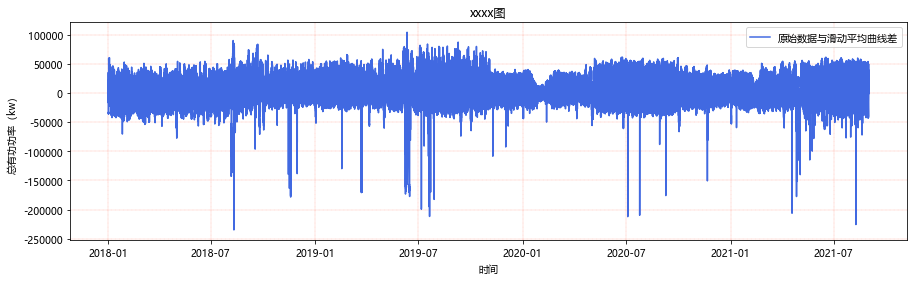

In [9]:
plt.figure(figsize=(15,4))
plt.grid(color = 'tomato', linestyle = '--', linewidth = 0.25)
plt.title('xxxx图')
plt.ylabel('总有功功率（kw）')
plt.xlabel('时间')
plt.plot(data_sub, color='royalblue', label='原始数据与滑动平均曲线差')
plt.legend()
# plt.savefig('每日功率波动曲线去除异常值前后对比图.svg')

{'whiskers': [<matplotlib.lines.Line2D at 0x1718c481fa0>,
 'caps': [<matplotlib.lines.Line2D at 0x1718c492700>,
 'boxes': [<matplotlib.lines.Line2D at 0x1718c481c10>],
 'medians': [<matplotlib.lines.Line2D at 0x1718c492e20>],
 'fliers': [<matplotlib.lines.Line2D at 0x1718c49e1f0>],
 'means': []}

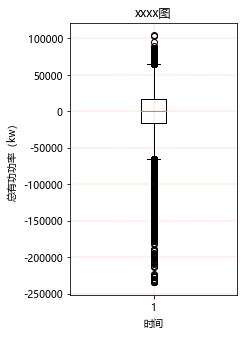

In [10]:
plt.figure(figsize=(3,5))
plt.grid(color = 'tomato', linestyle = '--', linewidth = 0.25)
plt.title('xxxx图')
plt.ylabel('总有功功率（kw）')
plt.xlabel('时间')
plt.boxplot(data_sub.iloc[:,0])
# plt.savefig('每日功率波动曲线去除异常值前后对比图.svg')

In [11]:
data_sub.describe().loc[['25%','75%']]

,总有功功率（kw）
25%,-16310.019634
75%,16193.010775


In [12]:
# 通过箱线图去除异常值
q1 = data_sub.quantile(0.25)[0]
q3 = data_sub.quantile(0.75)[0]

# 分别为箱线图的上界和下界
upper_whisker = q3 + 1.5*(q3-q1)
lower_whisker = q1 - 1.5*(q3-q1)

rule = (lower_whisker > data_sub) | (upper_whisker < data_sub)
rule.sum()

总有功功率（kw）    825
dtype: int64

In [13]:
# 由于2018年九月以前的数据整体太高了，作为异常值舍弃
data_drop_outlier = data['2018-09':].copy()
data_drop_outlier.loc[rule.iloc[:,0]] = np.NaN

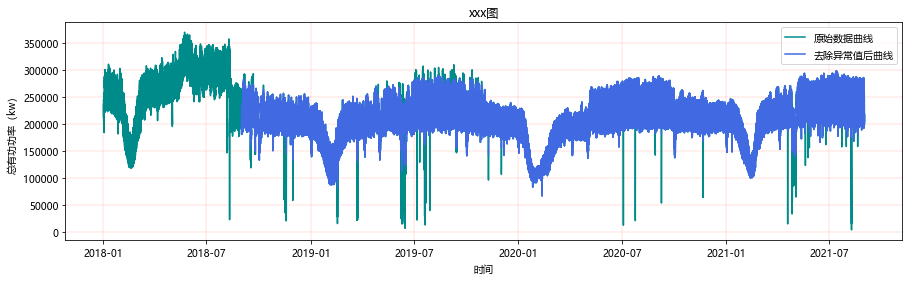

In [14]:
plt.figure(figsize=(15,4))
plt.grid(color = 'tomato', linestyle = '--', linewidth = 0.25)
plt.title('xxx图')
plt.ylabel('总有功功率（kw）')
plt.xlabel('时间')
plt.plot(data, color='darkcyan', label='原始数据曲线')
plt.plot(data_drop_outlier, color='royalblue', label='去除异常值后曲线')
plt.legend()
# plt.savefig('每日功率波动曲线去除异常值前后对比图.svg')

In [15]:
data_drop_outlier.isna().sum()

总有功功率（kw）    630
dtype: int64

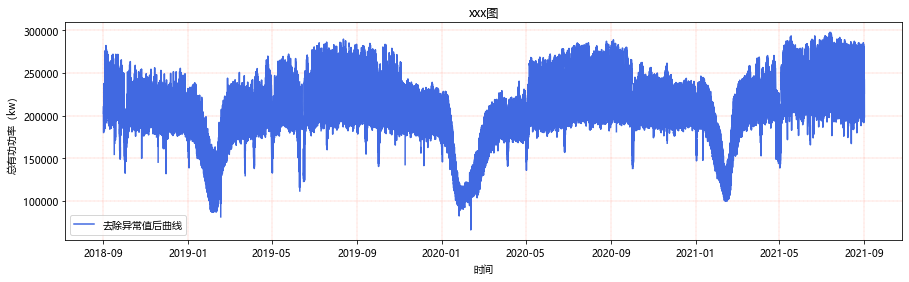

In [16]:
plt.figure(figsize=(15,4))
plt.grid(color = 'tomato', linestyle = '--', linewidth = 0.25)
plt.title('xxx图')
plt.ylabel('总有功功率（kw）')
plt.xlabel('时间')
# plt.plot(data, color='darkcyan', label='原始数据曲线')
plt.plot(data_drop_outlier, color='royalblue', label='去除异常值后曲线')
plt.legend()
# plt.savefig('每日功率波动曲线去除异常值前后对比图.svg')

In [17]:
day_mean = data_drop_outlier.resample('D').mean()

In [18]:
day_mean

,总有功功率（kw）
数据时间,
2018-09-01,204419.665854
2018-09-02,202904.469875
2018-09-03,219628.693339
2018-09-04,225435.323247
2018-09-05,231291.198122
...,...
2021-08-27,233404.093516
2021-08-28,229713.641184
2021-08-29,224129.369634


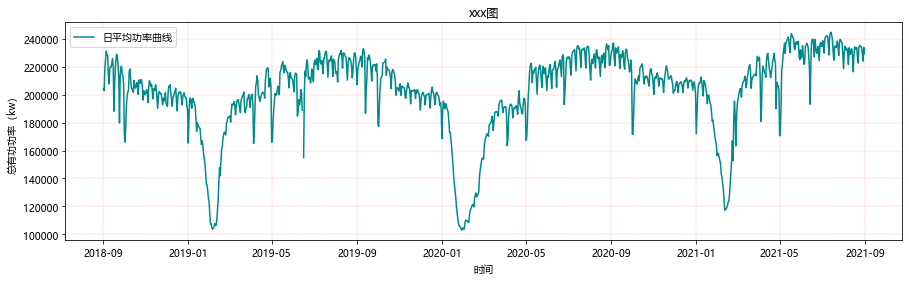

In [19]:
plt.figure(figsize=(15,4))
plt.grid(color = 'tomato', linestyle = '--', linewidth = 0.25)
plt.title('xxx图')
plt.ylabel('总有功功率（kw）')
plt.xlabel('时间')
plt.plot(day_mean, color='darkcyan', label='日平均功率曲线')
# plt.plot(data_drop_outlier, color='royalblue', label='去除异常值后曲线')
plt.legend()
# plt.savefig('每日功率波动曲线去除异常值前后对比图.svg')

In [20]:
def FB(data1, column):
    df = pd.DataFrame({
        'ds': pd.Series(data1.iloc[:,column].index),
        'y': pd.Series(data1.iloc[:,column].values)
        })
    df['cap'] = data1.iloc[:,column].max()
    df['floor'] = data1.iloc[:,column].min()
    
    m = Prophet(
        changepoint_prior_scale=0.2, 
        daily_seasonality=False,
        yearly_seasonality=True, #年周期性
        weekly_seasonality=True, #周周期
        growth="linear",
        interval_width=0.8 #置信区间宽度，有多大概率落在浅蓝色线里

    )

    m.add_country_holidays(country_name='CN')#中国所有的节假日    

    m.fit(df)

    future = m.make_future_dataframe(periods=10)
    future['cap'] = data1.iloc[:,column].max()
    future['floor'] = data1.iloc[:,column].min()

    forecast = m.predict(future)

    fig1 = m.plot(forecast)
    fig2 = m.plot_components(forecast)
    return future, forecast

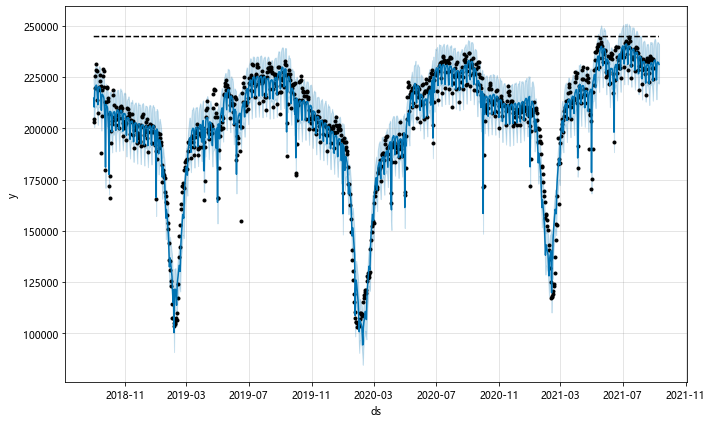

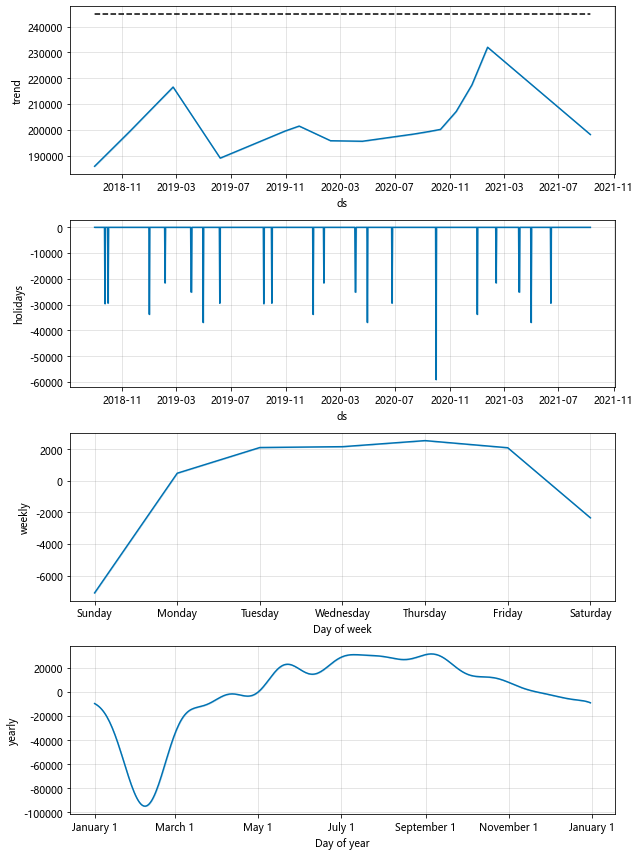

In [21]:
future, forecast = FB(day_mean, 0)

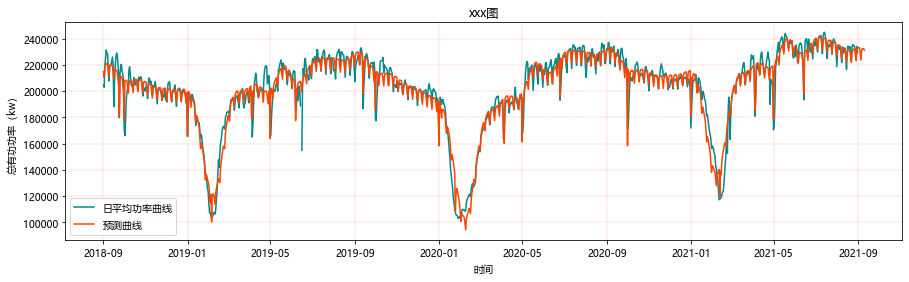

In [22]:
plt.figure(figsize=(15,4))
plt.grid(color = 'tomato', linestyle = '--', linewidth = 0.25)
plt.title('xxx图')
plt.ylabel('总有功功率（kw）')
plt.xlabel('时间')
plt.plot(day_mean, color='darkcyan', label='日平均功率曲线')
plt.plot(forecast.ds, forecast.yhat, color='orangered', label='预测曲线')
plt.legend()
# plt.savefig('每日功率波动曲线去除异常值前后对比图.svg')

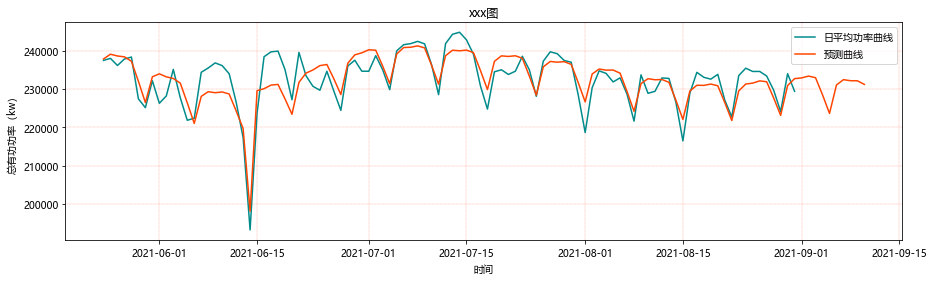

In [23]:
begin = 100
plt.figure(figsize=(15,4))
plt.grid(color = 'tomato', linestyle = '--', linewidth = 0.25)
plt.title('xxx图')
plt.ylabel('总有功功率（kw）')
plt.xlabel('时间')
plt.plot(day_mean[-begin:], color='darkcyan', label='日平均功率曲线')
plt.plot(forecast.ds[-begin-10:], forecast.yhat[-begin-10:], color='orangered', label='预测曲线')
plt.legend()
# plt.savefig('每日功率波动曲线去除异常值前后对比图.svg')

In [24]:
# 预测未来十天每日平均功率
predict = pd.DataFrame(np.asarray(forecast.yhat[-10:]), index=pd.date_range('2021-09-01','2021-09-10'), columns=['总有功功率（kw）'])
predict.index.name = '数据时间'
predict.to_csv('./未来十天日平均功率预测值.csv')

In [25]:
predict

,总有功功率（kw）
数据时间,
2021-09-01,232911.338319
2021-09-02,233385.736710
2021-09-03,232970.831293
2021-09-04,228504.715252
2021-09-05,223649.930655
2021-09-06,231071.241739
2021-09-07,232455.230434
2021-09-08,232181.404010
2021-09-09,232155.256459
